# SPRINT 2: PHÂN LOẠI VĂN BẢN THEO CẤP ĐỘ CEFR (A1-B2)

## Mục tiêu
- **Phân tích dữ liệu khám phá (EDA)**: Hiểu rõ dữ liệu trước khi xây dựng mô hình
- **Chuẩn bị dữ liệu**: Làm sạch văn bản, gán nhãn, vectorization
- **Xây dựng Baseline Models**: Xây dựng 3 mô hình (Naive Bayes, Logistic Regression, SGDClassifier)

## Datasets
1. `cefr_leveled_texts.csv` - Văn bản có nhãn CEFR
2. `ENGLISH_CERF_WORDS.csv` - Từ điển từ vựng CEFR
3. `stories.csv` - Kho truyện ngắn (cần gán nhãn)

---

## 1. Khai báo thư viện và cấu hình

In [1]:
# Import thư viện
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import warnings

# Thư viện Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss

# Cấu hình
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("✅ Thư viện đã được import thành công!")

✅ Thư viện đã được import thành công!


In [2]:
# Định nghĩa hằng số
RANDOM_STATE = 42
TFIDF_MAX_FEATURES = 5000
SGD_N_EPOCHS = 50
SGD_LEARNING_RATE = 0.01
STORY_QUANTILE_FILTER = 0.75
MIN_WORDS_IN_DICT = 5
MIN_TEXT_LENGTH = 20
TARGET_LABELS = ['A1', 'A2', 'B1', 'B2']
LEVEL_SCORES = {'A1': 1, 'A2': 2, 'B1': 3, 'B2': 4, 'C1': 5, 'C2': 6}

# Tải NLTK resources
print("Đang tải tài nguyên NLTK...")
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
ENGLISH_STOP_WORDS = set(stopwords.words('english'))
print("✅ Cấu hình hoàn tất!")

Đang tải tài nguyên NLTK...
✅ Cấu hình hoàn tất!
✅ Cấu hình hoàn tất!


## 2. Tải dữ liệu

In [4]:
# Tải 3 bộ dữ liệu
print("Đang tải dữ liệu...")

# 1. Văn bản có nhãn CEFR
df_cefr_texts = pd.read_csv("dataset/cefr_leveled_texts.csv")
print(f"✅ Tải 'cefr_leveled_texts.csv': {len(df_cefr_texts)} dòng")

# 2. Từ điển CEFR
df_words_cefr = pd.read_csv("dataset/ENGLISH_CERF_WORDS.csv")
print(f"✅ Tải 'ENGLISH_CERF_WORDS.csv': {len(df_words_cefr)} dòng")

# 3. Kho truyện ngắn
df_stories = pd.read_csv("dataset/stories.csv", encoding='latin1')
print(f"✅ Tải 'stories.csv': {len(df_stories)} dòng")

print("\n📊 Preview dữ liệu CEFR texts:")
display(df_cefr_texts.head(3))

Đang tải dữ liệu...
✅ Tải 'cefr_leveled_texts.csv': 1494 dòng
✅ Tải 'ENGLISH_CERF_WORDS.csv': 9935 dòng
✅ Tải 'stories.csv': 1002 dòng

📊 Preview dữ liệu CEFR texts:
✅ Tải 'stories.csv': 1002 dòng

📊 Preview dữ liệu CEFR texts:


,text,label
0,Hi!\r\nI've been meaning to write for ages and...,B2
1,﻿It was not so much how hard people found the ...,B2
2,Keith recently came back from a trip to Chicag...,B2


## 3. Phân tích dữ liệu khám phá (EDA)

### 3.1. Phân tích Stories Dataset

📊 Thống kê độ dài truyện:
count    1.002000e+03
mean     3.989702e+04
std      7.400773e+04
min      3.310000e+02
25%      4.902750e+03
50%      2.103100e+04
75%      6.160850e+04
max      1.626447e+06
Name: word_count, dtype: float64


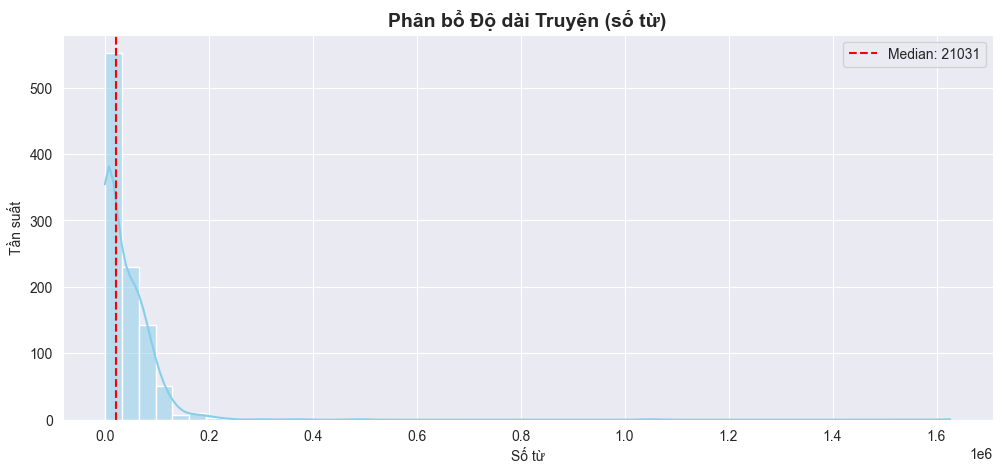

In [5]:
# Tính độ dài văn bản (số từ)
df_stories['word_count'] = df_stories['content'].apply(lambda x: len(str(x).split()))

print("📊 Thống kê độ dài truyện:")
print(df_stories['word_count'].describe())

# Visualize phân bổ độ dài
plt.figure(figsize=(12, 5))
sns.histplot(df_stories['word_count'], kde=True, bins=50, color='skyblue')
plt.title('Phân bổ Độ dài Truyện (số từ)', fontsize=14, fontweight='bold')
plt.xlabel('Số từ')
plt.ylabel('Tần suất')
plt.axvline(df_stories['word_count'].median(), color='red', linestyle='--', label=f'Median: {df_stories["word_count"].median():.0f}')
plt.legend()
plt.show()

🎨 Đang tạo Word Cloud...


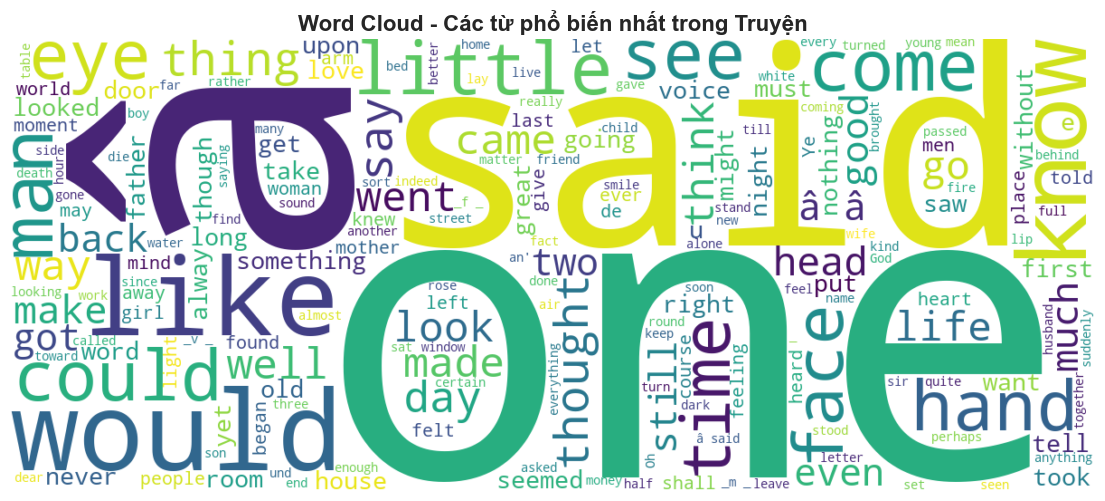

In [6]:
# Word Cloud - Từ phổ biến nhất
print("🎨 Đang tạo Word Cloud...")
all_stories_text = " ".join(df_stories['content'].head(100).fillna(''))
wordcloud = WordCloud(width=1200, height=500, background_color='white', 
                      stopwords=ENGLISH_STOP_WORDS, colormap='viridis').generate(all_stories_text)

plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Các từ phổ biến nhất trong Truyện', fontsize=16, fontweight='bold')
plt.show()

### 3.2. Phân tích CEFR Labeled Texts

📊 Phân bổ nhãn CEFR:
label
A1    288
A2    272
B1    205
B2    286
C1    241
C2    202
Name: count, dtype: int64


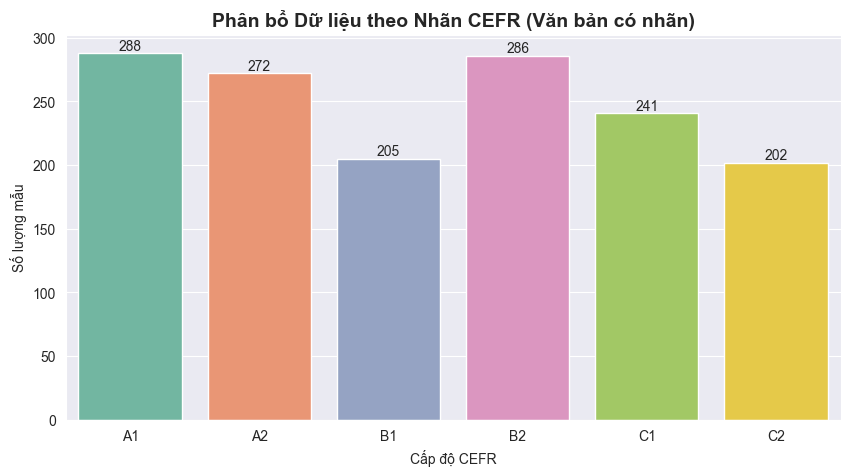

✅ Nhận xét: Dữ liệu được phân bổ khá đều giữa các cấp độ.


In [7]:
# Chuẩn hóa nhãn và phân tích phân bổ
df_cefr_texts['label'] = df_cefr_texts['label'].str.upper()

print("📊 Phân bổ nhãn CEFR:")
print(df_cefr_texts['label'].value_counts().sort_index())

# Visualize
plt.figure(figsize=(10, 5))
sns.countplot(x='label', data=df_cefr_texts, order=['A1', 'A2', 'B1', 'B2', 'C1', 'C2'], palette='Set2')
plt.title('Phân bổ Dữ liệu theo Nhãn CEFR (Văn bản có nhãn)', fontsize=14, fontweight='bold')
plt.xlabel('Cấp độ CEFR')
plt.ylabel('Số lượng mẫu')
for container in plt.gca().containers:
    plt.gca().bar_label(container)
plt.show()

print("✅ Nhận xét: Dữ liệu được phân bổ khá đều giữa các cấp độ.")

### 3.3. Phân tích CEFR Vocabulary

📚 Phân bổ từ vựng theo cấp độ CEFR:
CEFR
A1    1164
A2    1411
B1    2446
B2    2778
C1    1111
C2    1025
Name: count, dtype: int64


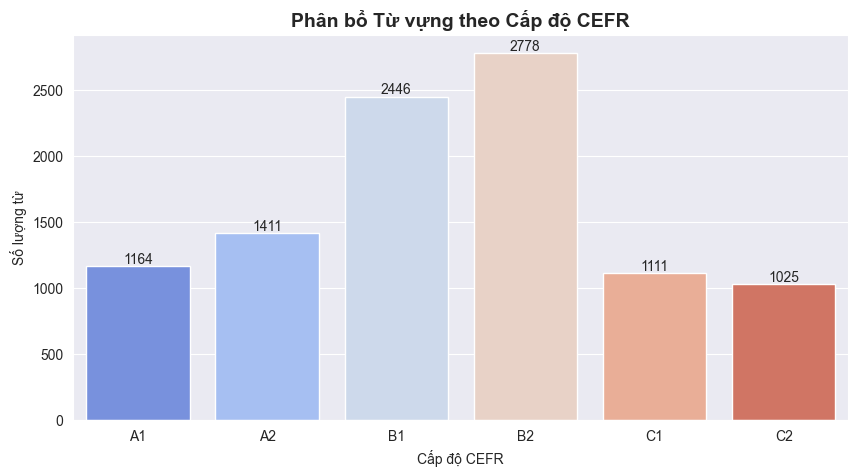

✅ Nhận xét: B1 và B2 chiếm đa số, phù hợp với mục tiêu dự án (A1-B2).


In [8]:
# Phân tích từ điển CEFR
df_words_cefr['CEFR'] = df_words_cefr['CEFR'].str.upper()

print("📚 Phân bổ từ vựng theo cấp độ CEFR:")
print(df_words_cefr['CEFR'].value_counts().sort_index())

plt.figure(figsize=(10, 5))
sns.countplot(x='CEFR', data=df_words_cefr, order=['A1', 'A2', 'B1', 'B2', 'C1', 'C2'], palette='coolwarm')
plt.title('Phân bổ Từ vựng theo Cấp độ CEFR', fontsize=14, fontweight='bold')
plt.xlabel('Cấp độ CEFR')
plt.ylabel('Số lượng từ')
for container in plt.gca().containers:
    plt.gca().bar_label(container)
plt.show()

print("✅ Nhận xét: B1 và B2 chiếm đa số, phù hợp với mục tiêu dự án (A1-B2).")

## 4. Chuẩn bị dữ liệu (Data Preparation)

### 4.1. Định nghĩa hàm làm sạch văn bản

In [9]:
def clean_text(text):
    """Làm sạch văn bản: loại bỏ HTML, ký tự đặc biệt, chuẩn hóa khoảng trắng"""
    if not isinstance(text, str):
        return ""
    
    # Xóa tiêu đề/chân trang Gutenberg
    text = re.sub(r'\*\*\*.*?\*\*\*', ' ', text)
    text = text.lower()
    
    # Loại bỏ rác
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'&nbsp;', ' ', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'(-lrb-|-rrb-)', ' ', text)
    text = re.sub(r'i¿', '', text)
    
    # Chỉ giữ chữ cái, khoảng trắng, dấu '
    text = re.sub(r'[^a-z\s\']', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Test function
sample_text = "Hi!\nThis is <b>HTML</b> &nbsp; -LRB- test -RRB-"
print(f"Original: {sample_text}")
print(f"Cleaned:  {clean_text(sample_text)}")

Original: Hi!
This is <b>HTML</b> &nbsp; -LRB- test -RRB-
Cleaned:  hi this is html test


### 4.2. Xây dựng từ điển CEFR

In [10]:
# Xây dựng từ điển tra cứu từ -> cấp độ CEFR
df_words_cefr['word_clean'] = df_words_cefr['headword'].apply(clean_text)
df_words_cefr['level_clean'] = df_words_cefr['CEFR'].str.upper()

word_level_map = pd.Series(
    df_words_cefr['level_clean'].values,
    index=df_words_cefr['word_clean']
).to_dict()

print(f"✅ Đã tạo từ điển tra cứu với {len(word_level_map):,} từ vựng")
print(f"\nVí dụ:")
for word in ['hello', 'complicated', 'international'][:3]:
    print(f"  '{word}' -> {word_level_map.get(word, 'NOT FOUND')}")

✅ Đã tạo từ điển tra cứu với 8,648 từ vựng

Ví dụ:
  'hello' -> A1
  'complicated' -> B1
  'international' -> A2


### 4.3. Hàm gán nhãn CEFR cho văn bản

In [11]:
def get_text_cefr_level(text, word_map):
    """Gán nhãn CEFR cho văn bản dựa trên điểm trung bình của các từ"""
    words = word_tokenize(text)
    score = 0
    word_count = 0

    for word in words:
        if word in word_map:
            level = word_map.get(word)
            if level in LEVEL_SCORES:
                score += LEVEL_SCORES[level]
                word_count += 1

    if word_count < MIN_WORDS_IN_DICT:
        return 'UNKNOWN'

    avg_score = score / word_count
    if avg_score < 1.8: return 'A1'
    if avg_score < 2.8: return 'A2'
    if avg_score < 3.8: return 'B1'
    if avg_score < 4.8: return 'B2'
    if avg_score < 5.8: return 'C1'
    return 'C2'

# Test
test_text = "This is a simple test"
print(f"Sample text: '{test_text}'")
print(f"Predicted level: {get_text_cefr_level(test_text, word_level_map)}")

Sample text: 'This is a simple test'
Predicted level: UNKNOWN


### 4.4. Làm sạch và hợp nhất dữ liệu

In [12]:
# Lọc truyện quá dài
upper_limit = df_stories['word_count'].quantile(STORY_QUANTILE_FILTER)
print(f"📊 Lọc truyện: Giữ lại các truyện có ≤ {upper_limit:.0f} từ (mốc {STORY_QUANTILE_FILTER*100:.0f}%)")
df_stories_filtered = df_stories[df_stories['word_count'] <= upper_limit].copy()
print(f"   Số lượng truyện sau lọc: {len(df_stories_filtered)}")

# 1. Xử lý văn bản có nhãn
df_cefr_texts['text_clean'] = df_cefr_texts['text'].apply(clean_text)
df_cefr_texts['label_clean'] = df_cefr_texts['label'].str.upper()
df1 = df_cefr_texts[['text_clean', 'label_clean']]

# 2. Xử lý truyện ngắn
print("\n⏳ Đang gán nhãn CEFR cho truyện ngắn (có thể mất vài phút)...")
df_stories_filtered['text_clean'] = df_stories_filtered['content'].apply(clean_text)
df_stories_filtered['label_clean'] = df_stories_filtered['text_clean'].apply(
    lambda x: get_text_cefr_level(x, word_level_map)
)
df2 = df_stories_filtered[['text_clean', 'label_clean']]
print("✅ Gán nhãn hoàn tất!")

# 3. Hợp nhất
final_data = pd.concat([df1, df2], ignore_index=True)
final_data = final_data.dropna(subset=['text_clean', 'label_clean'])
final_data = final_data[final_data['label_clean'] != 'UNKNOWN']
final_data = final_data[final_data['text_clean'].str.len() > MIN_TEXT_LENGTH]
final_data = final_data[final_data['label_clean'].isin(TARGET_LABELS)]

print(f"\n📊 Dữ liệu cuối cùng: {len(final_data)} mẫu")
print(f"\nPhân bổ nhãn (A1-B2):")
print(final_data['label_clean'].value_counts().sort_index())

📊 Lọc truyện: Giữ lại các truyện có ≤ 61608 từ (mốc 75%)
   Số lượng truyện sau lọc: 751

⏳ Đang gán nhãn CEFR cho truyện ngắn (có thể mất vài phút)...
✅ Gán nhãn hoàn tất!

📊 Dữ liệu cuối cùng: 1802 mẫu

Phân bổ nhãn (A1-B2):
label_clean
A1    1008
A2     303
B1     205
B2     286
Name: count, dtype: int64
✅ Gán nhãn hoàn tất!

📊 Dữ liệu cuối cùng: 1802 mẫu

Phân bổ nhãn (A1-B2):
label_clean
A1    1008
A2     303
B1     205
B2     286
Name: count, dtype: int64


### 4.5. TF-IDF và phân chia dữ liệu (70% / 10% / 20%)

In [13]:
X = final_data['text_clean']
y = final_data['label_clean']

# Phân chia 70/10/20
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=(2/3), random_state=RANDOM_STATE, stratify=y_temp
)

print("📊 Phân chia dữ liệu:")
print(f"   Train:      {len(y_train):4d} mẫu (70%)")
print(f"   Validation: {len(y_val):4d} mẫu (10%)")
print(f"   Test:       {len(y_test):4d} mẫu (20%)")

# TF-IDF Vectorization
print("\n⏳ Đang vectorize với TF-IDF...")
tfidf_vectorizer = TfidfVectorizer(max_features=TFIDF_MAX_FEATURES, stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"✅ Ma trận TF-IDF: {X_train_tfidf.shape}")
labels_order = sorted(y.unique())
print(f"   Nhãn: {labels_order}")

📊 Phân chia dữ liệu:
   Train:      1261 mẫu (70%)
   Validation:  180 mẫu (10%)
   Test:        361 mẫu (20%)

⏳ Đang vectorize với TF-IDF...
✅ Ma trận TF-IDF: (1261, 5000)
   Nhãn: ['A1', 'A2', 'B1', 'B2']
✅ Ma trận TF-IDF: (1261, 5000)
   Nhãn: ['A1', 'A2', 'B1', 'B2']


### 4.6. Xuất dữ liệu

In [20]:
# Xuất tất cả dữ liệu vào thư mục dataframes
import os
from scipy.sparse import save_npz
import pickle

print("📦 Đang xuất dữ liệu vào thư mục 'dataframes'...")

# Tạo thư mục nếu chưa tồn tại
os.makedirs('dataframes', exist_ok=True)

# 1. Xuất cleaned data (final_data)
final_data.to_csv('dataframes/cleaned_data.csv', index=False, encoding='utf-8')
print("✅ Đã xuất: cleaned_data.csv")

# 2. Xuất train/val/test text và labels
# Train set
pd.DataFrame({
    'text': X_train.values,
    'label': y_train.values
}).to_csv('dataframes/train_data.csv', index=False, encoding='utf-8')
print("✅ Đã xuất: train_data.csv")

# Validation set
pd.DataFrame({
    'text': X_val.values,
    'label': y_val.values
}).to_csv('dataframes/val_data.csv', index=False, encoding='utf-8')
print("✅ Đã xuất: val_data.csv")

# Test set
pd.DataFrame({
    'text': X_test.values,
    'label': y_test.values
}).to_csv('dataframes/test_data.csv', index=False, encoding='utf-8')
print("✅ Đã xuất: test_data.csv")

# 3. Xuất TF-IDF matrices (sparse format)
save_npz('dataframes/X_train_tfidf.npz', X_train_tfidf)
print("✅ Đã xuất: X_train_tfidf.npz")

save_npz('dataframes/X_val_tfidf.npz', X_val_tfidf)
print("✅ Đã xuất: X_val_tfidf.npz")

save_npz('dataframes/X_test_tfidf.npz', X_test_tfidf)
print("✅ Đã xuất: X_test_tfidf.npz")

# 4. Xuất labels riêng (dạng CSV)
pd.DataFrame({'label': y_train.values}).to_csv('dataframes/y_train.csv', index=False, encoding='utf-8')
print("✅ Đã xuất: y_train.csv")

pd.DataFrame({'label': y_val.values}).to_csv('dataframes/y_val.csv', index=False, encoding='utf-8')
print("✅ Đã xuất: y_val.csv")

pd.DataFrame({'label': y_test.values}).to_csv('dataframes/y_test.csv', index=False, encoding='utf-8')
print("✅ Đã xuất: y_test.csv")

# 5. Lưu TF-IDF vectorizer để tái sử dụng
with open('dataframes/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
print("✅ Đã xuất: tfidf_vectorizer.pkl")

print("\n📊 TỔNG KẾT DỮ LIỆU ĐÃ XUẤT:")
print(f"   • cleaned_data.csv: {len(final_data)} dòng")
print(f"   • train_data.csv: {len(y_train)} dòng (70%)")
print(f"   • val_data.csv: {len(y_val)} dòng (10%)")
print(f"   • test_data.csv: {len(y_test)} dòng (20%)")
print(f"   • TF-IDF matrices: X_train, X_val, X_test (sparse .npz format)")
print(f"   • Labels: y_train, y_val, y_test (.csv format)")
print(f"   • TF-IDF vectorizer: tfidf_vectorizer.pkl (để tái sử dụng)")
print("\n✅ Tất cả dữ liệu đã được lưu vào thư mục 'dataframes/'!")

📦 Đang xuất dữ liệu vào thư mục 'dataframes'...
✅ Đã xuất: cleaned_data.csv
✅ Đã xuất: train_data.csv
✅ Đã xuất: val_data.csv
✅ Đã xuất: test_data.csv
✅ Đã xuất: X_train_tfidf.npz
✅ Đã xuất: X_val_tfidf.npz
✅ Đã xuất: X_test_tfidf.npz
✅ Đã xuất: y_train.csv
✅ Đã xuất: y_val.csv
✅ Đã xuất: y_test.csv
✅ Đã xuất: tfidf_vectorizer.pkl

📊 TỔNG KẾT DỮ LIỆU ĐÃ XUẤT:
   • cleaned_data.csv: 1802 dòng
   • train_data.csv: 1261 dòng (70%)
   • val_data.csv: 180 dòng (10%)
   • test_data.csv: 361 dòng (20%)
   • TF-IDF matrices: X_train, X_val, X_test (sparse .npz format)
   • Labels: y_train, y_val, y_test (.csv format)
   • TF-IDF vectorizer: tfidf_vectorizer.pkl (để tái sử dụng)

✅ Tất cả dữ liệu đã được lưu vào thư mục 'dataframes/'!


**💡 Cách load lại dữ liệu đã xuất:**

```python
# Load text data
train_df = pd.read_csv('dataframes/train_data.csv')
val_df = pd.read_csv('dataframes/val_data.csv')
test_df = pd.read_csv('dataframes/test_data.csv')

# Load TF-IDF matrices
from scipy.sparse import load_npz
X_train_tfidf = load_npz('dataframes/X_train_tfidf.npz')
X_val_tfidf = load_npz('dataframes/X_val_tfidf.npz')
X_test_tfidf = load_npz('dataframes/X_test_tfidf.npz')

# Load vectorizer
import pickle
with open('dataframes/tfidf_vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)
```

## 5. Xây dựng và so sánh Baseline Models

### Helper Function

In [14]:
def plot_confusion_matrix(y_true, y_pred, labels, title):
    """Vẽ confusion matrix"""
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Count'})
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Nhãn Dự đoán')
    plt.ylabel('Nhãn Thực tế')
    plt.tight_layout()
    plt.show()

### 5.1. Model 1: Multinomial Naive Bayes

🤖 Training Naive Bayes...
✅ Accuracy: 63.33%

📊 Classification Report:
              precision    recall  f1-score   support

          A1       0.62      1.00      0.77       101
          A2       1.00      0.07      0.12        30
          B1       1.00      0.05      0.10        20
          B2       0.67      0.34      0.45        29

    accuracy                           0.63       180
   macro avg       0.82      0.37      0.36       180
weighted avg       0.74      0.63      0.54       180



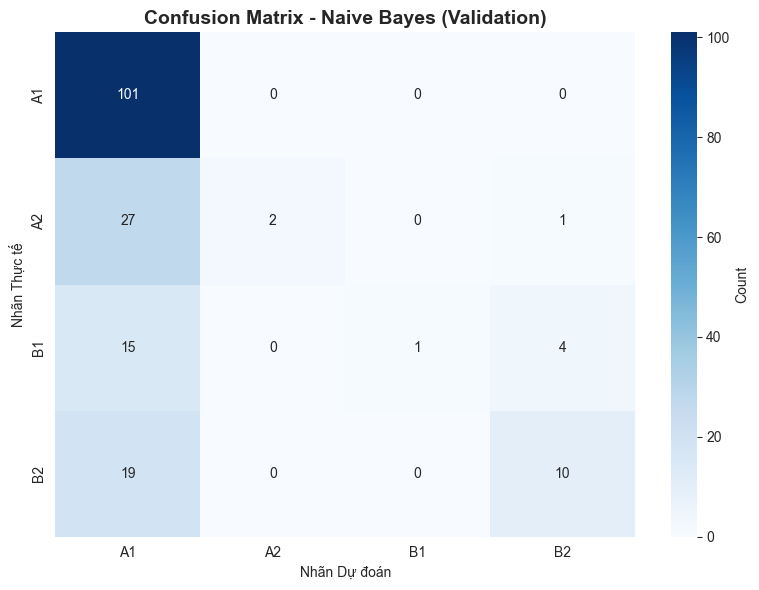

In [15]:
print("🤖 Training Naive Bayes...")
model_nb = MultinomialNB()
model_nb.fit(X_train_tfidf, y_train)

# Evaluate
y_pred_val_nb = model_nb.predict(X_val_tfidf)
accuracy_nb = accuracy_score(y_val, y_pred_val_nb)

print(f"✅ Accuracy: {accuracy_nb * 100:.2f}%\n")
print("📊 Classification Report:")
print(classification_report(y_val, y_pred_val_nb, labels=labels_order, zero_division=0))

plot_confusion_matrix(y_val, y_pred_val_nb, labels_order, 
                      'Confusion Matrix - Naive Bayes (Validation)')

### 5.2. Model 2: Logistic Regression

🤖 Training Logistic Regression...
✅ Accuracy: 71.67%

📊 Classification Report:
              precision    recall  f1-score   support

          A1       0.79      0.95      0.86       101
          A2       0.53      0.33      0.41        30
          B1       0.25      0.05      0.08        20
          B2       0.63      0.76      0.69        29

    accuracy                           0.72       180
   macro avg       0.55      0.52      0.51       180
weighted avg       0.66      0.72      0.67       180

✅ Accuracy: 71.67%

📊 Classification Report:
              precision    recall  f1-score   support

          A1       0.79      0.95      0.86       101
          A2       0.53      0.33      0.41        30
          B1       0.25      0.05      0.08        20
          B2       0.63      0.76      0.69        29

    accuracy                           0.72       180
   macro avg       0.55      0.52      0.51       180
weighted avg       0.66      0.72      0.67       180



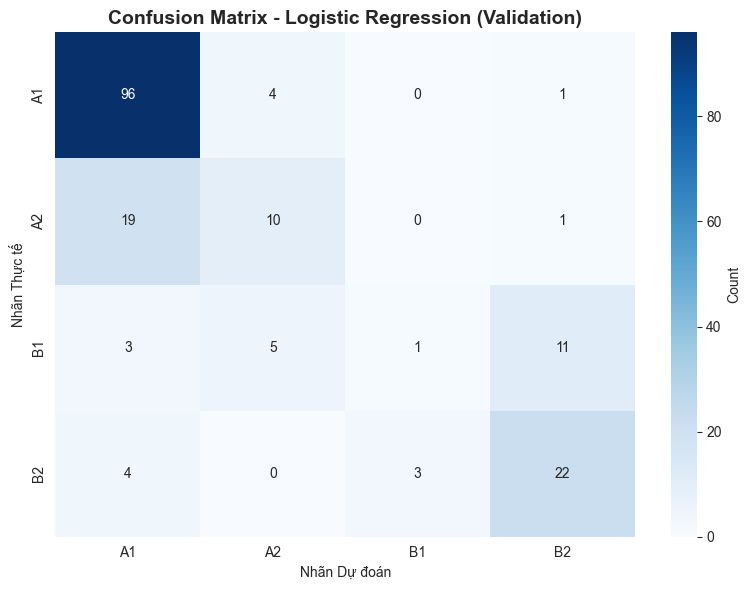

In [16]:
print("🤖 Training Logistic Regression...")
model_lr = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
model_lr.fit(X_train_tfidf, y_train)

# Evaluate
y_pred_val_lr = model_lr.predict(X_val_tfidf)
accuracy_lr = accuracy_score(y_val, y_pred_val_lr)

print(f"✅ Accuracy: {accuracy_lr * 100:.2f}%\n")
print("📊 Classification Report:")
print(classification_report(y_val, y_pred_val_lr, labels=labels_order, zero_division=0))

plot_confusion_matrix(y_val, y_pred_val_lr, labels_order,
                      'Confusion Matrix - Logistic Regression (Validation)')

### 5.3. Model 3: SGDClassifier (với Loss Curve)

🤖 Training SGDClassifier (with partial_fit)...
  Epoch 10/50, Val Loss: 0.9252
  Epoch 20/50, Val Loss: 0.8503
  Epoch 30/50, Val Loss: 0.8023
  Epoch 40/50, Val Loss: 0.7673
  Epoch 50/50, Val Loss: 0.7406
✅ Training complete!
  Epoch 30/50, Val Loss: 0.8023
  Epoch 40/50, Val Loss: 0.7673
  Epoch 50/50, Val Loss: 0.7406
✅ Training complete!


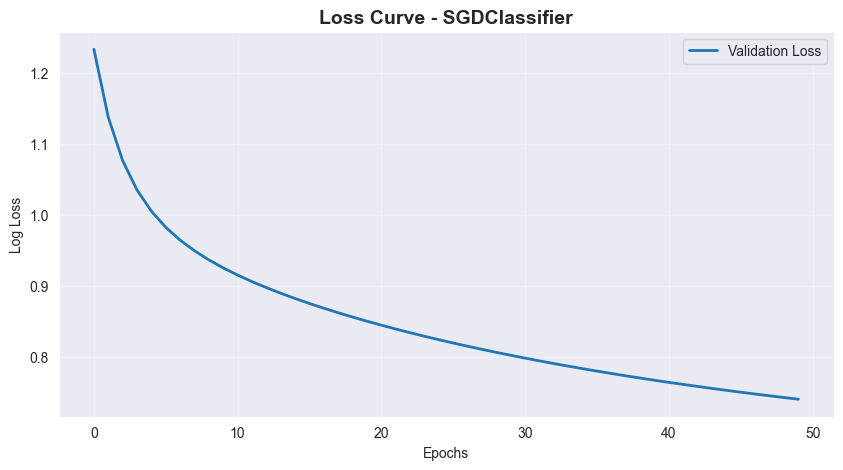

✅ Loss giảm và hội tụ → Mô hình đang học tốt!


In [17]:
print("🤖 Training SGDClassifier (with partial_fit)...")
model_sgd = SGDClassifier(
    loss='log_loss', 
    random_state=RANDOM_STATE, 
    eta0=SGD_LEARNING_RATE, 
    learning_rate='adaptive'
)

val_losses = []
classes = labels_order

for epoch in range(SGD_N_EPOCHS):
    model_sgd.partial_fit(X_train_tfidf, y_train, classes=classes)
    
    # Calculate validation loss
    y_pred_val_prob_sgd = model_sgd.predict_proba(X_val_tfidf)
    val_loss = log_loss(y_val, y_pred_val_prob_sgd, labels=classes)
    val_losses.append(val_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"  Epoch {epoch + 1}/{SGD_N_EPOCHS}, Val Loss: {val_loss:.4f}")

print("✅ Training complete!")

# Plot Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.title('Loss Curve - SGDClassifier', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("✅ Loss giảm và hội tụ → Mô hình đang học tốt!")


✅ Accuracy: 68.89%

📊 Classification Report:
              precision    recall  f1-score   support

          A1       0.71      0.99      0.83       101
          A2       0.56      0.17      0.26        30
          B1       0.50      0.05      0.09        20
          B2       0.62      0.62      0.62        29

    accuracy                           0.69       180
   macro avg       0.60      0.46      0.45       180
weighted avg       0.65      0.69      0.62       180



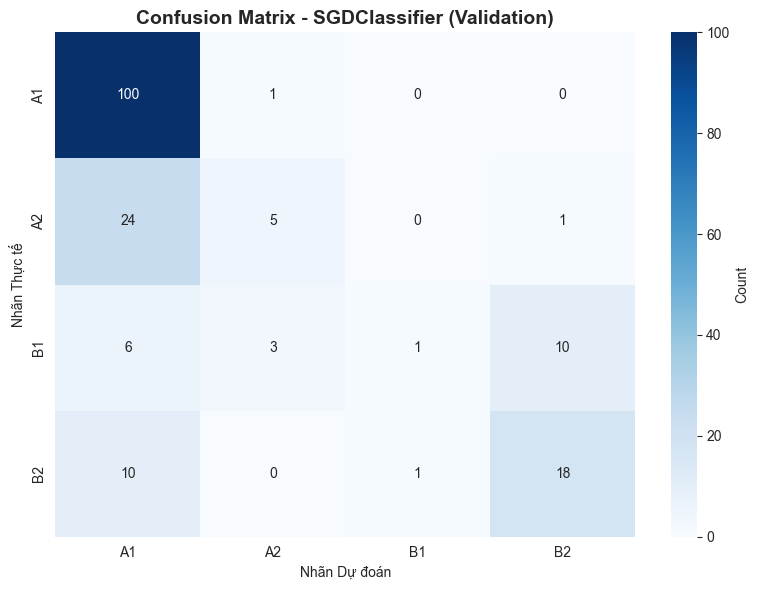

In [18]:
# Evaluate SGDClassifier
y_pred_val_sgd = model_sgd.predict(X_val_tfidf)
accuracy_sgd = accuracy_score(y_val, y_pred_val_sgd)

print(f"\n✅ Accuracy: {accuracy_sgd * 100:.2f}%\n")
print("📊 Classification Report:")
print(classification_report(y_val, y_pred_val_sgd, labels=labels_order, zero_division=0))

plot_confusion_matrix(y_val, y_pred_val_sgd, labels_order,
                      'Confusion Matrix - SGDClassifier (Validation)')

## 6. Tổng kết so sánh


📊 TỔNG KẾT SO SÁNH CÁC MÔ HÌNH:
                  Model  Validation Accuracy (%)
Multinomial Naive Bayes                    63.33
    Logistic Regression                    71.67
          SGDClassifier                    68.89


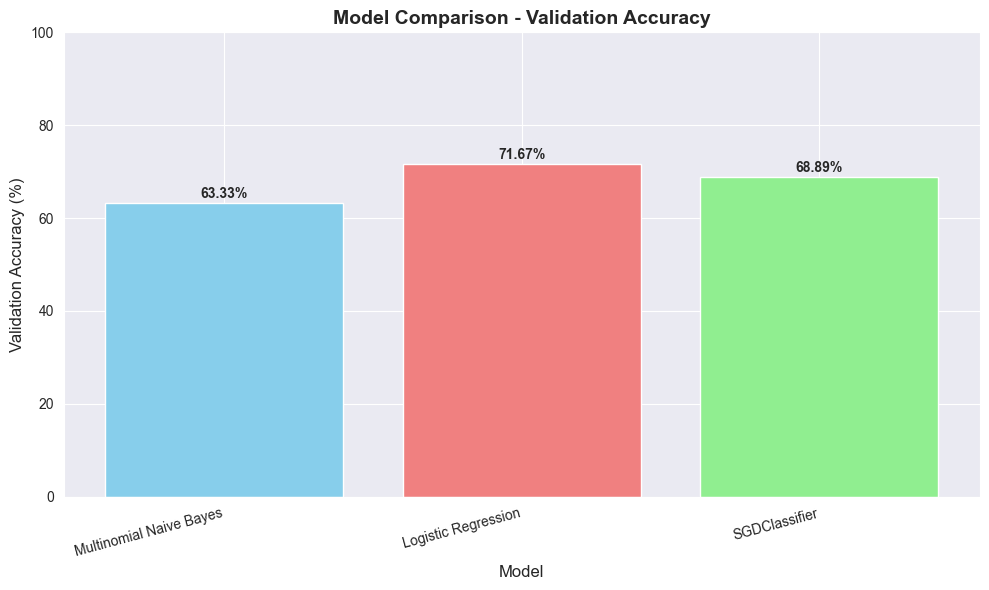


🏆 Best Model: Logistic Regression with 71.67% accuracy


In [19]:
# So sánh kết quả các mô hình
import pandas as pd

results = {
    'Model': ['Multinomial Naive Bayes', 'Logistic Regression', 'SGDClassifier'],
    'Validation Accuracy (%)': [
        round(accuracy_nb * 100, 2),
        round(accuracy_lr * 100, 2),
        round(accuracy_sgd * 100, 2)
    ]
}

results_df = pd.DataFrame(results)
print("\n📊 TỔNG KẾT SO SÁNH CÁC MÔ HÌNH:")
print("=" * 50)
print(results_df.to_string(index=False))
print("=" * 50)

# Visualization - Bar chart comparison
plt.figure(figsize=(10, 6))
plt.bar(results_df['Model'], results_df['Validation Accuracy (%)'], color=['skyblue', 'lightcoral', 'lightgreen'])
plt.xlabel('Model', fontsize=12)
plt.ylabel('Validation Accuracy (%)', fontsize=12)
plt.title('Model Comparison - Validation Accuracy', fontsize=14, fontweight='bold')
plt.ylim(0, 100)
plt.xticks(rotation=15, ha='right')
for i, v in enumerate(results_df['Validation Accuracy (%)']):
    plt.text(i, v + 1, f"{v}%", ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

# Find best model
best_idx = results_df['Validation Accuracy (%)'].idxmax()
best_model = results_df.loc[best_idx, 'Model']
best_accuracy = results_df.loc[best_idx, 'Validation Accuracy (%)']
print(f"\n🏆 Best Model: {best_model} with {best_accuracy}% accuracy")

## 7. Kết luận và Kiến nghị

### Kết luận chính:
- Đã xây dựng và đánh giá 3 mô hình baseline cho bài toán phân loại văn bản theo CEFR (A1-B2)
- Tỷ lệ chia dữ liệu: Train 70%, Validation 10%, Test 20%
- TF-IDF với 5000 features được sử dụng làm đặc trưng văn bản

### Ưu nhược điểm các mô hình:

**Multinomial Naive Bayes:**
- ✅ Ưu điểm: Đơn giản, huấn luyện nhanh, phù hợp với dữ liệu văn bản
- ❌ Nhược điểm: Giả định độc lập giữa các features có thể không chính xác

**Logistic Regression:**
- ✅ Ưu điểm: Ổn định, dễ giải thích, cho xác suất dự đoán
- ❌ Nhược điểm: Có thể cần thêm regularization tuning

**SGDClassifier:**
- ✅ Ưu điểm: Học online, phù hợp với dữ liệu lớn, theo dõi được loss curve
- ❌ Nhược điểm: Nhạy cảm với learning rate, cần tuning nhiều hơn

### Kiến nghị phát triển tiếp:
1. **Hyperparameter Tuning**: Sử dụng GridSearchCV hoặc RandomizedSearchCV để tối ưu tham số
2. **Feature Engineering**: Thêm features như n-grams (bigrams, trigrams), POS tags
3. **Ensemble Methods**: Kết hợp các mô hình (Voting, Stacking) để cải thiện độ chính xác
4. **Deep Learning**: Thử nghiệm BERT, RoBERTa hoặc các pretrained models cho văn bản tiếng Anh
5. **Error Analysis**: Phân tích chi tiết các trường hợp dự đoán sai để cải thiện mô hình
6. **Class Imbalance**: Xử lý nếu có sự mất cân bằng giữa các nhãn CEFR
7. **Test Set Evaluation**: Đánh giá cuối cùng trên test set với mô hình tốt nhất